### Getting started with Cyclic Ordering with Feature Extraction (COFE) on synthetic data

In [1]:
# Import necessary libraries and modules
import anndata as ad               # For AnnData data container
import COFE as cf                  # For COFE analysis functions
import matplotlib as mp            # For plotting
import numpy as np                 # For numerical operations
from sklearn import metrics        # For evaluation precision-recall performance
from SyntheticData import *        # For generating synthetic datasets

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

### Step 1: Generating Synthetic Data

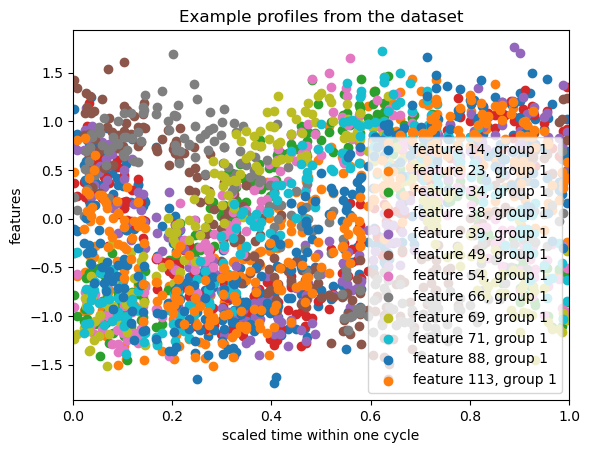

In [2]:
## Define dataset parameters
n_genes = 2000     # Total number of genes/transcripts in the synthetic dataset
n_samples = 200    # Number of samples used for training
n_test = 25        # Number of samples used for testing

# Initialize the data generator with the defined parameters
data = SyntheticData(n_genes, n_samples + n_test)

# Define oscillation frequencies in radians/hour
# Here, we are specifying a single rhythmic group.
data.oscillatory_groups(1)

# Generate the synthetic dataset
# - normal_dist_times=False: Times are uniformly spaced instead of normally distributed
# - rhy_frac=0.1: 10% of genes are rhythmic
X_synthetic, group_info, _ = data.generate_data(normal_dist_times=False, 
                                                    rhy_frac=0.1)

# Extract true sample times (used for validation later)
time = data.t  # True sample times that COFE does not "see" during analysis

# Add noise to the dataset
# st_dev=0.25 adds Gaussian noise with a standard deviation of 0.25
X = data.corrupt(X_synthetic, st_dev=0.25)


# Place the data and metadata within one AnnData object
adata = ad.AnnData(X.T)
adata.obs_names = [f"S{i+1:d}" for i in range(adata.n_obs)]
adata.var_names = [f"g{i+1:d}" for i in range(adata.n_vars)]
adata.obs["time"] = data.t * 24.0
adata.uns["period"] = 24.0
adata.var["rhythmic"] = np.isin(np.arange(adata.n_vars), group_info[1])
## Split the dataset into training and testing sets
adata.obs["train"] = [True] * n_samples + [False] * n_test

# Visualize the generated dataset
# group_info provides labels for rhythmic and arrhythmic genes
data.plot_X(X, group_info, [(1, 12)])

### Step 2: Data Preprocessing

In [ ]:
# Standardize the dataset for analysis
adata = cf.preprocess_data(adata, scale=True)

# Check the true labels for rhythmic and arrhythmic genes
rhythmic_genes = [f"g{i+1:d}" for i in group_info[1]]    # Indices of truly rhythmic genes
arrhythmic_genes = [f"g{i+1:d}" for i in group_info[0]]  # Indices of truly arrhythmic genes

### Step 3: Running COFE Analysis

In [5]:
# Define candidate sparsity parameter values
s_choices = np.linspace(1, 30, 15)  # Range of sparsity parameters to evaluate

# Perform cross-validation to train the model
# - K=5: Number of folds for cross-validation
# - restarts=5: Number of restarts to ensure robustness
# - ncores=-1: Use all available CPU cores for parallel processing
# - repeats=3: Repeat cross-validation for stability
adata = cf.cross_validate(adata, s_choices=s_choices, K=5, restarts=5, ncores=-1, repeats=3)

# Generate phase predictions for training data
adata = cf.estimate_phase(adata)

### Step 4: Visualizing Results

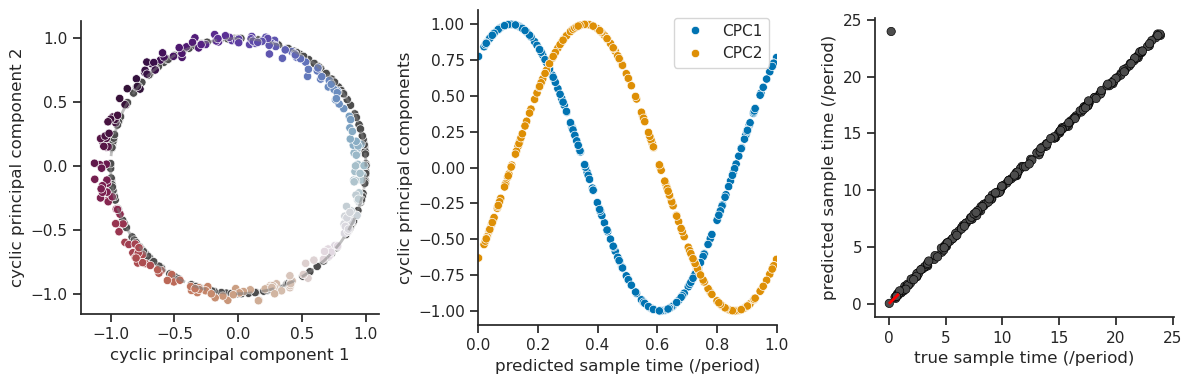

In [6]:
## Plot circular ordering of training data
# - period=1: Period of the rhythms on which true sample times are defined
cf.plot_circular_ordering(
    adata, figsize=(12, 4)
)

### Step 5: Evaluating Temporal Reordering Performance

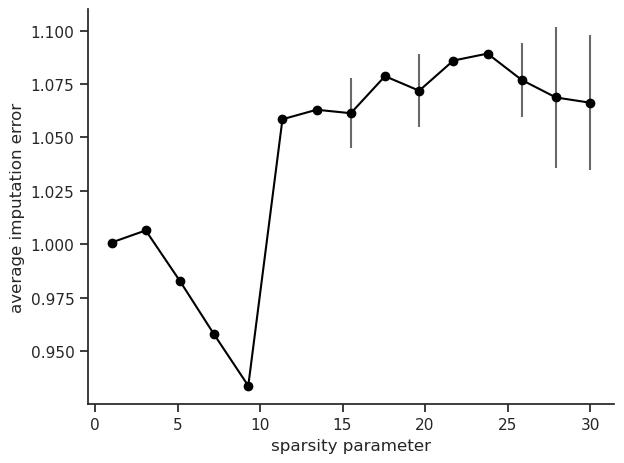

In [7]:
## Plot cross-validation results to find the optimal sparsity parameter
cf.plot_cv_run(adata)

In [8]:
# Phase prediction accuracy (as a fraction of 24 hours)
adata = cf.estimate_phase(adata, train=True)
train_mape = adata.uns["scpca"]["MAPE"]  # Training data accuracy
adata = cf.estimate_phase(adata, train=False)
test_mape = adata.uns["scpca"]["MAPE"]    # Testing data accuracy
print(f"Training MAPE: {train_mape:1.4f}")
print(f"Testing MAPE: {test_mape:1.4f}")

Training MAPE: 0.0054
Testing MAPE: 0.0060


### Step 6: Extracting Biomarkers and Evaluating Its Accuracy

In [9]:
## Display the list of predicted rhythmic genes (biomarkers)
markers = cf.print_markers(adata)

In [ ]:
# Performance of rhythmic feature identification using precision and recall
truth = [i in rhythmic_genes for i in adata.var_names]
prediction = [i in markers for i in adata.var_names]
print(f"Precision: {metrics.precision_score(truth, prediction):1.2f}, " 
       f"Recall: {metrics.recall_score(truth, prediction):1.2f}, " 
       f"Matthews correlation coefficient: {metrics.matthews_corrcoef(truth, prediction):1.2f}")

Precision: 0.00, Recall: 0.00, Matthews correlation coefficient: 0.00


/home/bharath/miniforge3/envs/phase_order-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [15]:
group_info[1]

[13,
 22,
 33,
 37,
 38,
 48,
 53,
 65,
 68,
 70,
 87,
 112,
 115,
 136,
 150,
 156,
 169,
 171,
 185,
 186,
 191,
 203,
 210,
 222,
 245,
 251,
 260,
 271,
 274,
 285,
 302,
 329,
 338,
 355,
 378,
 391,
 420,
 422,
 423,
 432,
 450,
 463,
 465,
 473,
 475,
 485,
 520,
 525,
 533,
 535,
 541,
 557,
 564,
 569,
 575,
 594,
 621,
 640,
 653,
 665,
 668,
 677,
 695,
 699,
 702,
 721,
 728,
 738,
 744,
 748,
 750,
 753,
 758,
 765,
 770,
 792,
 796,
 805,
 816,
 820,
 832,
 850,
 877,
 883,
 917,
 919,
 928,
 937,
 940,
 959,
 965,
 972,
 974,
 994,
 1008,
 1017,
 1023,
 1038,
 1049,
 1065,
 1068,
 1076,
 1083,
 1092,
 1095,
 1117,
 1119,
 1122,
 1124,
 1126,
 1131,
 1141,
 1150,
 1153,
 1156,
 1159,
 1160,
 1171,
 1176,
 1178,
 1217,
 1224,
 1232,
 1240,
 1255,
 1258,
 1265,
 1278,
 1293,
 1294,
 1298,
 1322,
 1323,
 1326,
 1332,
 1343,
 1351,
 1372,
 1388,
 1396,
 1398,
 1402,
 1405,
 1408,
 1438,
 1453,
 1469,
 1478,
 1482,
 1483,
 1500,
 1502,
 1503,
 1509,
 1515,
 1525,
 1527,
 1534,

### Exploring COFE Functions

In [ ]:
# Use ? to get detailed documentation for any COFE function
# For example, to learn about the cross_validate function:
?cf.cross_validate

Signature:
COFE.analyse.cross_validate(
    X_train,
    s_choices,
    features,
    feature_std=None,
    K=5,
    repeats=3,
    restarts=5,
    tol=0.001,
    tol_z=1e-06,
    max_iter=400,
    ncores=None,
)
Docstring:
Calculate the optimal choice of sparsity threshold 's' and the 
cyclic ordering for the best 's'

Parameters
----------
X_train : ndarray
    preprocessed training data matrix 
s_choices : array or list or None
    different values of l1 sparsity threshold to compare. If None 
    then directly computes non-sparse solution.
features: array
    names of the features
feature_std : array, optional
    weights for the different features that determine the st. dev. 
    of the random initial conditions each restart, by default None
K : int, optional
    number of folds used for cross-validation
repeats : int, optional
    the number of different random repetition (of the splits) in 
    K-fold cross-validation, by default 3
restarts : int, optional
    the number of rand